# Benjamin Tollison

In [7]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def PrintAirfoil(cooridnates):
  x_coords = cooridnates[:,0]
  y_coords = cooridnates[:,1]
  
  # Print the extracted coordinates
  # print("X coordinates:", x_coords)
  # print("Y coordinates:", y_coords)

  plt.figure(figsize=(8, 6))
  plt.plot(x_coords, y_coords)
  plt.gca().set_aspect('equal', adjustable='box')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Airfoil')
  plt.grid(True)
  plt.show()
  return None

In [9]:
def GenerateAirfoil(filename:str,thickness:float,camber:float)->list:
  """
  Modify NACA airfoil coordinates in a .dat file based on new thickness and camber parameters.
    
  Parameters:
      filename (str): Path to the .dat file containing NACA airfoil coordinates.
      new_thickness (float): New maximum thickness as a fraction of chord length (0.01 to 0.99).
      new_camber (float): New maximum camber as a fraction of chord length (0.0 to 0.05).
    
  Returns:
      numpy.ndarray: Modified NACA airfoil coordinates (x, y).
  """
  # Read existing airfoil coordinates from the .dat file
  airfoil_coords = np.loadtxt(filename)
    
  # Scale coordinates based on new thickness and camber parameters
  x = airfoil_coords[:, 0]
  y = airfoil_coords[:, 1]
  x_scaled = x
  y_scaled = y * (thickness / 0.12)  # Scale thickness
  y_scaled += (camber / 0.02) * 0.12 * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x ** 2 + 0.2843 * x ** 3 - 0.1015 * x ** 4)  # Scale camber
    
  # Combine scaled coordinates into a new array
  modified_airfoil_coords = np.column_stack([x_scaled, y_scaled])
  # Save modified airfoil coordinates to a new .dat file
  modified_filename = f"modified_{filename}"
  np.savetxt(modified_filename, modified_airfoil_coords, fmt='%1.6f', delimiter='\t')#, header=f"Modified Airfoil: {filename}", comments='')
  return modified_airfoil_coords

In [ ]:
def RunXfoil()

In [10]:
def LiftDragRatio(polar_input_dict):
  alpha = polar_input_dict['alpha']
  cl = polar_input_dict['CL']
  cd = polar_input_dict['CD']
  lift_over_drag_discrete = []
  for index in range(len(cl)):
    lift_over_drag_discrete.append(cl[index]/cd[index])
  polyfit_coeffiecients = np.polyfit(alpha,lift_over_drag_discrete,5)
  return np.poly1d(polyfit_coeffiecients)

In [11]:
def ObjectiveFunction(input_vector):
  thickness, camber = input_vector[0], input_vector[0]
  # params for XFOIL
  base_airfoil_file = 'NACA0012.dat'
  airfoil_name = 'modified_NACA0012.dat'
  alpha_i = 0
  alpha_f = 10
  alpha_step = 0.25
  Re = 1000000
  n_iter = 200

  new_coords = GenerateAirfoil(base_airfoil_file,thickness,camber)
  PrintAirfoil(new_coords)
  # %% XFOIL input file writer 

  if os.path.exists("polar_file.txt"):
      os.remove("polar_file.txt")

  input_file = open("input_file.in", 'w')
  input_file.write("LOAD {0}.dat\n".format(airfoil_name))
  input_file.write(airfoil_name + '\n')
  input_file.write("PANE\n")
  input_file.write("OPER\n")
  input_file.write("Visc {0}\n".format(Re))
  input_file.write("PACC\n")
  input_file.write("polar_file.txt\n\n")
  input_file.write("ITER {0}\n".format(n_iter))
  input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f,alpha_step))
  input_file.write("\n\n")
  input_file.write("quit\n")
  input_file.close()
  subprocess.call("xfoil.exe < input_file.in", shell=True)
  polar_data = np.loadtxt("polar_file.txt", skiprows=12)

  data = {
      'alpha': [],
      'CL': [],
      'CD': [],
      'CDp': [],
      'CM': [],
      'Top_Xtr': [],
      'Bot_Xtr': []
  }
  # Open the file
  with open('polar_file.txt', 'r') as file:
  # Read each line in the file
    for line in file:
    # Split the line into words
      words = line.split()
      # Check if the line contains numerical data
      if len(words) == 7 and all(word.replace('.', '').isdigit() for word in words[1:]):
        # Extract the numerical data and convert to float
        alpha, CL, CD, CDp, CM, Top_Xtr, Bot_Xtr = map(float, words)
        # Append the data to the dictionary
        data['alpha'].append(alpha)
        data['CL'].append(CL)
        data['CD'].append(CD)
        data['CDp'].append(CDp)
        data['CM'].append(CM)
        data['Top_Xtr'].append(Top_Xtr)
        data['Bot_Xtr'].append(Bot_Xtr)
  lift_over_drag_function = LiftDragRatio(data)
  design_angle_of_attack = 3 #degrees
  lift_over_drag = lift_over_drag_function(design_angle_of_attack)
  return lift_over_drag


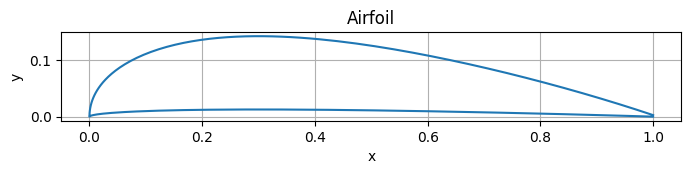

FileNotFoundError: polar_file.txt not found.

In [12]:
ObjectiveFunction([0.13,0.03])